### 웹크롤링 방법
 - 동적페이지: URL의 변경 없이 페이지의 내용이 변경 - json
 - 정적페이지: URL의 변경되면서 페이지의 내용이 변경 - html

In [3]:
import pandas as pd
import requests

#### 네이버 주가 데이터 수집
- 동적페이지: JSON
- PC 페이지가 복잡하면 모바일 페이지에서 수집

In [20]:
# 1. 웹서비스 분석: 개발자 도구 - URL
page_size, page = 20, 1
url = f"https://m.stock.naver.com/api/index/KOSPI/price?pageSize={page_size}&page={page}"
url

'https://m.stock.naver.com/api/index/KOSPI/price?pageSize=20&page=1'

In [7]:
# 2. 서버에 데이터 요청: requests(URL) > response(JSON(str))
response = requests.get(url)
response

<Response [200]>

In [11]:
response.text[:200]

'[{"localTradedAt":"2022-01-05","closePrice":"2,953.97","compareToPreviousClosePrice":"-35.27","compareToPreviousPrice":{"code":"5","text":"하락","name":"FALLING"},"fluctuationsRatio":"-1.18","openPrice"'

In [13]:
# 3. JSON(str) > parsing > dict, list > DataFrame
data = response.json()
type(data)

list

In [16]:
columns = ["localTradedAt", "closePrice"]
kospi_df = pd.DataFrame(data)[columns]
kospi_df.head()

,localTradedAt,closePrice
0,2022-01-05,"2,953.97"
1,2022-01-04,"2,989.24"
2,2022-01-03,"2,988.77"
3,2021-12-30,"2,977.65"
4,2021-12-29,"2,993.29"


In [21]:
len(kospi_df)

10

In [25]:
# 4. 함수로 만들기
def stock_price(code="KOSPI", page_size=20, page=1):
    """parameters: code(KOSPI or KOSDAQ)"""
    url = f"https://m.stock.naver.com/api/index/{code}/price?pageSize={page_size}&page={page}"
    # https://m.stock.naver.com/api/index/KOSDAQ/price?pageSize=10&page=2
    response = requests.get(url)
    data = response.json()
    return pd.DataFrame(data)[["localTradedAt", "closePrice"]]

df = stock_price("KOSDAQ")
df.head()

,localTradedAt,closePrice
0,2022-02-21,879.92
1,2022-02-18,881.71
2,2022-02-17,874.22
3,2022-02-16,878.15
4,2022-02-15,839.92


In [27]:
# 5. 실습: 원달러 환율 데이터 수집
def exchange_rate(code="FX_USDKRW", page_size=20, page=1):
    url = f"https://api.stock.naver.com/marketindex/exchange/{code}/prices?page={page}&pageSize={page_size}"
    response = requests.get(url)
    dollar = response.json()
    return pd.DataFrame(dollar)[["localTradedAt", "closePrice"]]
usd = exchange_rate()
usd.head()

,localTradedAt,closePrice
0,2022-02-21,"1,195.00"
1,2022-02-18,"1,195.50"
2,2022-02-17,"1,197.50"
3,2022-02-16,"1,198.00"
4,2022-02-15,"1,197.50"


In [29]:
# 시각화 및 상관관계 분석
%config InlineBackend.figure_formats = {'png', 'retina'}
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
# 데이터 수집: kospi, kosdaq, usd
kospi = stock_price()
kosdaq = stock_price("KOSDAQ")
usd = exchange_rate()

In [36]:
# 데이터 전처리: str > float
# kospi.dtypes
kospi["closePrice"] = kospi["closePrice"].apply(lambda data: float(data.replace(",","")))
kosdaq["closePrice"] = kosdaq["closePrice"].apply(lambda data: float(data.replace(",","")))
usd["closePrice"] = usd["closePrice"].apply(lambda data: float(data.replace(",","")))

In [37]:
usd.dtypes

localTradedAt     object
closePrice       float64
dtype: object

In [40]:
# lambda: 일회성 함수 - lambda params: return
def plus(num1, num2):
    return num1 + num2
def minus(num1, num2):
    return num1 - num2
def calc(func, num1, num2):
    return func(num1, num2)

calc(plus, 1, 2)

3

In [41]:
calc(lambda num1, num2: num1+num2, 1, 2)

3

In [42]:
# apply(func): 모든 데이터에 func을 적용시킨 결과를 출력

In [49]:
df = kospi.copy()
df = df.rename(columns={"localTradedAt": "date","closePrice": "kospi"})
df["kosdaq"] = kosdaq["closePrice"]
df["usd"] = usd["closePrice"]
df

,date,kospi,kosdaq,usd
0,2022-02-21,2737.97,881.64,1194.2
1,2022-02-18,2744.52,881.71,1195.5
2,2022-02-17,2744.09,874.22,1197.5
3,2022-02-16,2729.68,878.15,1198.0
4,2022-02-15,2676.54,839.92,1197.5
5,2022-02-14,2704.48,852.79,1197.5
6,2022-02-11,2747.71,877.42,1199.5
7,2022-02-10,2771.93,895.68,1196.5
8,2022-02-09,2768.85,910.53,1196.0
9,2022-02-08,2746.47,895.27,1198.5


In [50]:
df.dtypes

date       object
kospi     float64
kosdaq    float64
usd       float64
dtype: object

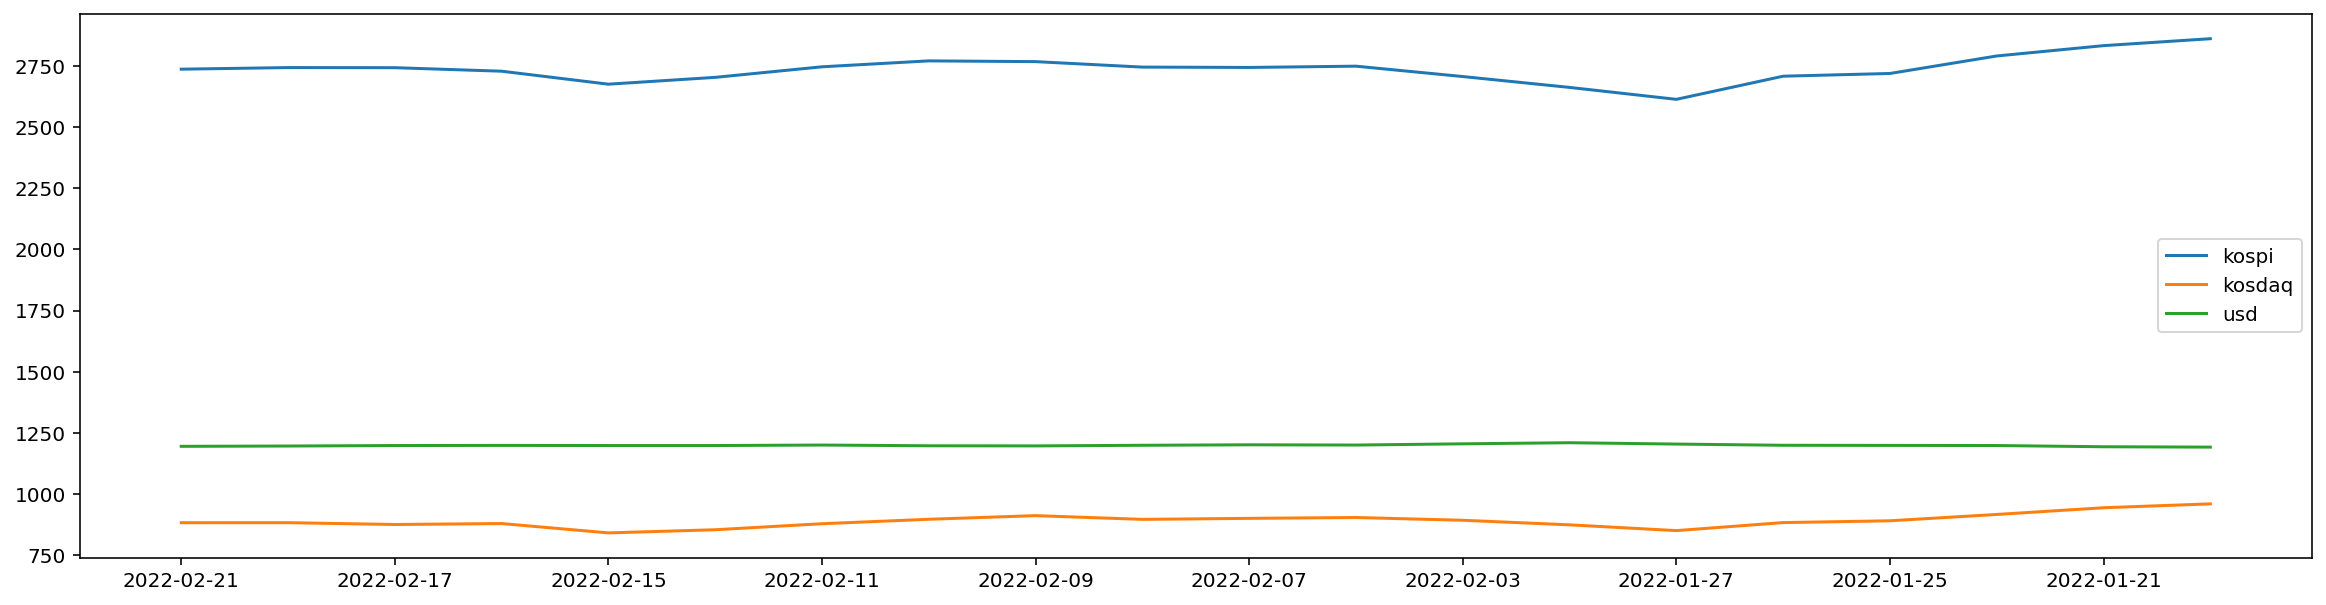

In [57]:
# 그래프 그리기
plt.figure(figsize=(20,5))
# plt.plot(df["date"], df["kospi"], label="kospi")
# plt.plot(df["date"], df["kosdaq"], label="kosdaq")
# plt.plot(df["date"], df["usd"], label="usd")

for i in df.columns[1:]:
    plt.plot(df["date"], df[i], label=i)
plt.xticks(df["date"][::2])
plt.legend()
plt.show()

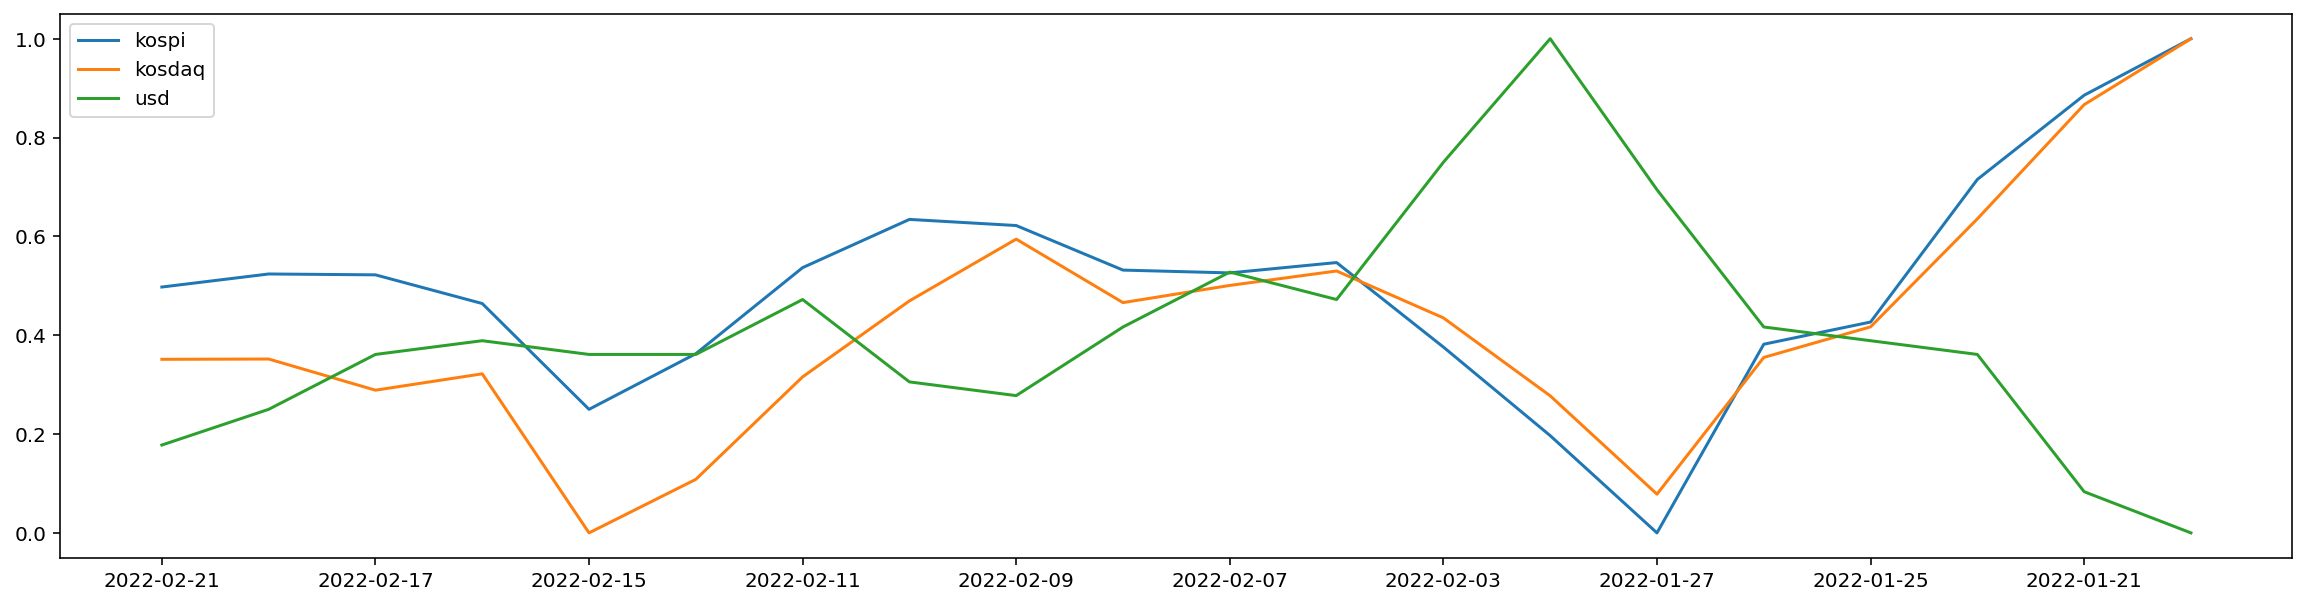

In [61]:
# 데이터 스케일링: min max scale
# z = (x-min(X))/(max(x)-min(x)): 0 <= z <= 1
from sklearn.preprocessing import minmax_scale

plt.figure(figsize=(20,5))

for i in df.columns[1:]:
    plt.plot(df["date"], minmax_scale(df[i]), label=i)
plt.xticks(df["date"][::2])
plt.legend()
plt.show()

In [67]:
# 상관관계 분석
# 상관계수 해석
# 0과 가까울수록 두 데이터는 관계가 없고
# +-1과 가까울수록 두 데이터는 강한 양의/음의 상관관계
df[df.columns[1:]].corr()

# kospi-kosdaq: 0.892 - 강한 양의 상관과계
# kospi-usd: -0.745 - 강한 음의 상관과계

,kospi,kosdaq,usd
kospi,1.000000,0.892546,-0.746816
kosdaq,0.892546,1.000000,-0.504849
usd,-0.746816,-0.504849,1.000000
